# Pendulum Equation Comparison: PINN vs RK4 vs Exact

In [ ]:
import numpy as np
import math
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad
import matplotlib.pyplot as plt

# -----------------------------------------------------------------------------
# 1) Problem Parameters
# -----------------------------------------------------------------------------
g        = 9.81
L        = 1.0
damping  = 0.1
θ0       = 0.5        # initial angle (small‐angle)
t_min    = 0.0
t_max    = 30.0

# -----------------------------------------------------------------------------
# 2) Exact small‐angle solution (for supervised data generation)
# -----------------------------------------------------------------------------
def exact_small_angle(t, θ0=θ0, g=g, L=L, d=damping):
    ωd2 = max(g/L - (d/2)**2, 0.0)
    ωd  = math.sqrt(ωd2)
    return θ0 * np.exp(-d*t/2) * np.cos(ωd * t)

# -----------------------------------------------------------------------------
# 3) RK4 integrator for the full nonlinear damped pendulum
# -----------------------------------------------------------------------------
class SinglePendulumRK4:
    def __init__(self, g, L, d, θ0, dt=1e-3, t_max=30.0):
        self.g, self.L, self.d = g, L, d
        self.θ0 = θ0
        self.dt = dt
        self.t_max = t_max

    def solve(self, times):
        times_sorted = sorted(times)
        hist = {}
        idx = 0
        next_t = times_sorted[idx]

        θ = self.θ0
        ω = 0.0
        t = 0.0
        steps = int(self.t_max/self.dt) + 1

        for _ in range(steps):
            if t >= next_t - self.dt/2:
                hist[next_t] = θ
                idx += 1
                if idx == len(times_sorted):
                    break
                next_t = times_sorted[idx]

            # RK4 step
            def deriv(θ, ω):
                return ω, -self.d*ω - (self.g/self.L)*math.sin(θ)

            k1θ, k1ω = deriv(θ, ω)
            k2θ, k2ω = deriv(θ + 0.5*self.dt*k1θ, ω + 0.5*self.dt*k1ω)
            k3θ, k3ω = deriv(θ + 0.5*self.dt*k2θ, ω + 0.5*self.dt*k2ω)
            k4θ, k4ω = deriv(θ +     self.dt*k3θ, ω +     self.dt*k3ω)

            θ += (self.dt/6)*(k1θ + 2*k2θ + 2*k3θ + k4θ)
            ω += (self.dt/6)*(k1ω + 2*k2ω + 2*k3ω + k4ω)
            t += self.dt

        return hist

# -----------------------------------------------------------------------------
# 4) PINN: Fourier‐SIREN embedding + MLP
# -----------------------------------------------------------------------------
class TimeFourier(nn.Module):
    def __init__(self, in_dim=1, mapping_size=256, scale=10.0):
        super().__init__()
        B = torch.randn(in_dim, mapping_size) * scale
        self.register_buffer('B', B)

    def forward(self, t):
        # t: [N,1]
        proj = 2*math.pi * t @ self.B      # [N, mapping_size]
        return torch.cat([torch.sin(proj), torch.cos(proj)], dim=-1)
    

class PINNPendODE(nn.Module):
    def __init__(self, g=9.81, L=1.0, d=0.1,
                 fourier_features=64,
                 hidden=[256,128]):
        super().__init__()
        self.g, self.L, self.d, self.t_max = g, L, d, t_max
        # Fourier embedding of time
        self.ff   = TimeFourier(1, fourier_features, scale=0.5)
        # SIREN‐style first layer
        self.lin0 = nn.Linear(2*fourier_features, hidden[0])
        self.ω0   = 30.0
        # remaining MLP
        layers = []
        for i in range(len(hidden)-1):
            layers += [nn.Linear(hidden[i], hidden[i+1]), nn.Tanh()]
        layers += [nn.Linear(hidden[-1], 1)]
        self.net = nn.Sequential(*layers)

        # ----- custom weight initialization -----
        # 1) SIREN init for the first linear:
        with torch.no_grad():
            fan_in = self.lin0.weight.size(1)
            bound = 1.0 / fan_in
            self.lin0.weight.uniform_(-bound, bound)
            self.lin0.bias.uniform_(-bound, bound)

        # 2) Xavier init for all other Linear layers:
        for m in self.net:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, t):
        # (optional) normalize t to [–1,1] first
        t_norm = 2*(t/self.t_max) - 1
        φ = self.ff(t_norm)  # [N,2M]
        h = torch.sin(self.ω0*self.lin0(φ)) # SIREN activation [N,1]
        y = self.net(h)          # now y≈cos(ω_d t)
        return torch.exp(-self.d*t/2)*y

    def loss_pde(self, t):
        t = t.clone().detach().requires_grad_(True)
        u   = self.forward(t)
        u_t = grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_tt= grad(u_t, t, grad_outputs=torch.ones_like(u_t), create_graph=True)[0]
        # residual: u_tt + d u_t + (g/L) sin(u) = 0
        res = u_tt + self.d*u_t + (self.g/self.L)*torch.sin(u)
        return torch.mean(res**2)

    def loss_ic(self, θ0_val=θ0):
        dev = next(self.parameters()).device
        t0  = torch.zeros(1, 1, device=dev, requires_grad=True)
        u0 = self.forward(t0)
        return (u0 - θ0_val)**2

# -----------------------------------------------------------------------------
# 5) Training: phase 1 = Adam + LR scheduler
# -----------------------------------------------------------------------------
device = torch.device('mps')
pinn   = PINNPendODE(g, L, damping).to(device)
opt    = optim.Adam(pinn.parameters(), lr=1e-4)
sched  = optim.lr_scheduler.StepLR(opt, step_size=2000, gamma=0.5)

w_pde, w_ic, w_data = 20.0, 10.0, 30.0
N_pde, N_data       = 5000, 2000

# precompute supervised data
t_data = torch.linspace(t_min, t_max, N_data, device=device).unsqueeze(-1)
u_data = torch.tensor(exact_small_angle(t_data.cpu().numpy()),
                      dtype=torch.float32, device=device).unsqueeze(-1)

for ep in range(1, 10001):
    # linearly increase w_pde from 0.1 to 10 over the first n epochs
    w_pde = 0.1 + 9.9 * min(ep/4000, 1.0)
    # PDE collocation
    t_pde = torch.rand(N_pde,1, device=device) * t_max
    lpde  = pinn.loss_pde(t_pde)
    lic   = pinn.loss_ic()
    upred = pinn(t_data)
    ldat  = nn.MSELoss()(upred, u_data)

    loss = w_pde*lpde + w_ic*lic + w_data*ldat

    opt.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(pinn.parameters(), max_norm=1.0)
    opt.step()
    sched.step()

    if ep % 1000 == 0:
        print("Epoch {}: PDE={:.2e}, IC={:.2e}, DATA={:.2e}"
          .format(ep, lpde.item(), lic.item(), ldat.item()))

# -----------------------------------------------------------------------------
# 6) Training: phase 2 = L-BFGS refinement
# -----------------------------------------------------------------------------
print("Starting L-BFGS refinement…")
# move model and data to CPU
pinn_cpu   = pinn.cpu()
t_data_cpu = t_data.cpu()
u_data_cpu = u_data.cpu()

lbfgs = torch.optim.LBFGS(
    pinn_cpu.parameters(),
    lr=1.0,
    max_iter=500,
    tolerance_grad=1e-8,
    line_search_fn='strong_wolfe'
)

def closure():
    lbfgs.zero_grad()
    # Sample PDE collocation points on CPU
    t_pde_cpu = torch.rand(N_pde, 1) * t_max  # default dtype and device=CPU
    lpde  = pinn_cpu.loss_pde(t_pde_cpu)
    lic   = pinn_cpu.loss_ic()
    # Data loss on CPU
    upred = pinn_cpu(t_data_cpu)
    ldat  = nn.MSELoss()(upred, u_data_cpu)
    # Combine all losses with the same weights used in phase 1
    loss = w_pde * lpde + w_ic * lic + w_data * ldat
    loss.backward()
    return loss

final_loss = lbfgs.step(closure)
print("L-BFGS final loss:", final_loss.item())

# -----------------------------------------------------------------------------
# 7) Evaluate & plot line traces
# -----------------------------------------------------------------------------
pinn.eval()
t_vals = np.linspace(t_min, t_max, 1000)
U_ex   = exact_small_angle(t_vals)
rk4    = SinglePendulumRK4(g, L, damping, θ0, dt=1e-3, t_max=t_max)

dt      = 1e-3
ts      = np.arange(0, t_max+dt, dt)
hist    = rk4.solve(ts.tolist())
θ_vals  = np.array([hist[t] for t in ts])
U_fd    = np.interp(t_vals, ts, θ_vals)

with torch.no_grad():
    tt_cpu = torch.tensor(t_vals[:, None], dtype=torch.float32)
    U_pr = pinn(tt_cpu).cpu().numpy().flatten()

plt.figure(figsize=(8,4))
plt.plot(t_vals, U_ex, 'k--', lw=2, label=r'Exact $\theta_0 = 0.5$')
plt.plot(t_vals, U_fd, 'b-',  label='RK4')
plt.plot(t_vals, U_pr, 'rx',  label='PINN', alpha=0.4)
plt.xlabel('t'); plt.ylabel(r'$\theta(t)$')
plt.legend(); plt.grid(True)
plt.tight_layout()
plt.show()


/Users/josegarcia/Documents/Cursor/PINNs-RL-PDE/pinn/lib/python3.13/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([2000, 1, 1])) that is different to the input size (torch.Size([2000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


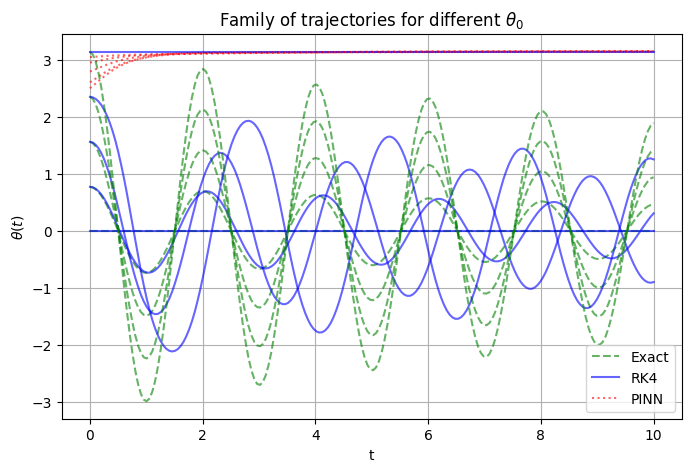

In [22]:
# pick a handful of initial‐angles to show, e.g. 5 evenly spaced:
n_plots = 5
idxs = np.linspace(0, Nθ-1, n_plots, dtype=int)

fig, ax = plt.subplots(figsize=(8,5))
for idx in idxs:
    label = fr"$\theta_0={θ0_vals[idx]:.2f}$"
    ax.plot(t_vals,  U_ex[idx,:],  'g--', alpha=0.6, label="Exact" if idx==idxs[0] else None)
    ax.plot(t_vals,  U_fd[idx,:],  'b-',  alpha=0.6, label="RK4" if idx==idxs[0] else None)
    ax.plot(t_vals,  U_pr[idx,:],  'r:', alpha=0.6, label="PINN"    if idx==idxs[0] else None)

ax.set_xlabel("t")
ax.set_ylabel(r"$\theta(t)$")
ax.set_title(r"Family of trajectories for different $\theta_{0}$")
ax.grid(True)
ax.legend()
plt.show()